In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
!git clone https://github.com/lusiaulia/learn.git

fatal: destination path 'learn' already exists and is not an empty directory.


In [3]:
data_train = pd.read_csv('/content/learn/Time Series/DailyDelhiClimateTrain.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [6]:
data_train = data_train.drop(['meantemp','humidity','meanpressure'],axis=1)
data_train

,date,wind_speed
0,2013-01-01,0.000000
1,2013-01-02,2.980000
2,2013-01-03,4.633333
3,2013-01-04,1.233333
4,2013-01-05,3.700000
...,...,...
1457,2016-12-28,3.547826
1458,2016-12-29,6.000000
1459,2016-12-30,6.266667
1460,2016-12-31,7.325000


<Axes: >

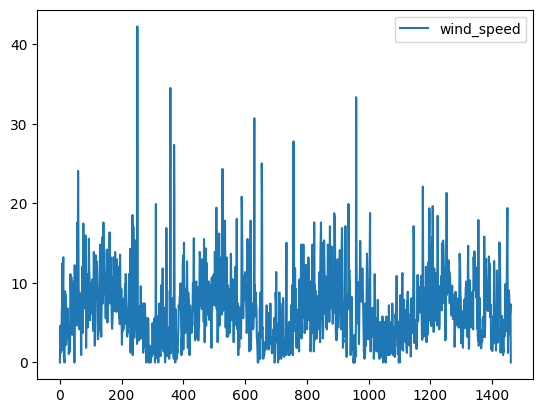

In [7]:
data_train.plot()

In [8]:
series = np.array(data_train.wind_speed)
time = np.array(data_train.date)
min = np.min(series)
max = np.max(series)
series -= min
series /= max

split_time = round(len(series)*0.8)

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(x_train, window_size=window_size,
                                 batch_size=batch_size, shuffle_buffer=1000)

In [9]:
model = Sequential()
model.add(LSTM(100, return_sequences=True))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

learning_rate = 1e-5
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

In [10]:
history = model.fit(train_set, epochs=30)

Epoch 1/30
36/36 [==============================] - 11s 61ms/step - loss: 0.0183 - mae: 0.1557
Epoch 2/30
36/36 [==============================] - 2s 43ms/step - loss: 0.0171 - mae: 0.1485
Epoch 3/30
36/36 [==============================] - 2s 39ms/step - loss: 0.0160 - mae: 0.1418
Epoch 4/30
36/36 [==============================] - 2s 40ms/step - loss: 0.0151 - mae: 0.1354
Epoch 5/30
36/36 [==============================] - 2s 37ms/step - loss: 0.0141 - mae: 0.1294
Epoch 6/30
36/36 [==============================] - 3s 68ms/step - loss: 0.0133 - mae: 0.1238
Epoch 7/30
36/36 [==============================] - 2s 46ms/step - loss: 0.0125 - mae: 0.1186
Epoch 8/30
36/36 [==============================] - 2s 44ms/step - loss: 0.0118 - mae: 0.1138
Epoch 9/30
36/36 [==============================] - 1s 21ms/step - loss: 0.0111 - mae: 0.1095
Epoch 10/30
36/36 [==============================] - 1s 21ms/step - loss: 0.0105 - mae: 0.1054
Epoch 11/30
36/36 [==============================] - 1s 20

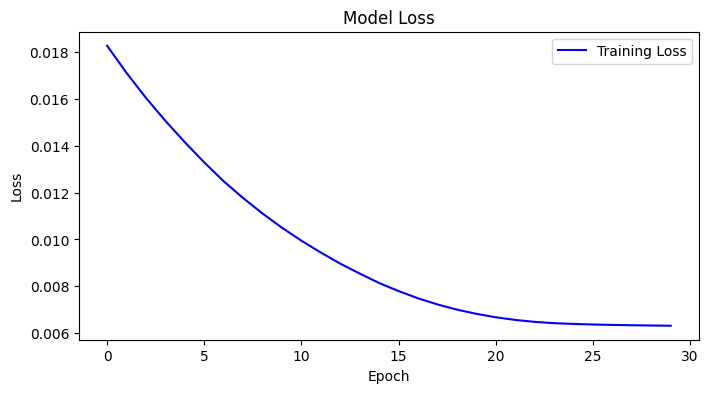

In [11]:
#Loss Curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Model Loss')
plt.legend(loc=0)
# plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

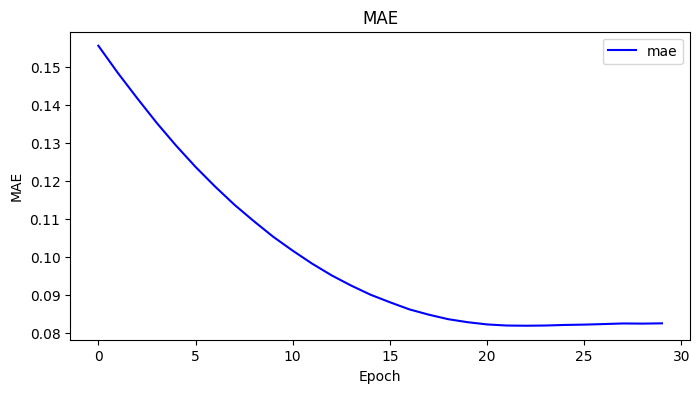

In [12]:
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'], label='mae', color='blue')
plt.title('MAE')
plt.legend(loc=0)
# plt.grid(True)
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.show();